In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pybeam.default as pbd

# modify figure text settings
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({ 'mathtext.default' : 'regular' })


In [2]:
# define base model
model = {'type' : 'base',  # model type ('base' or 'ugm')
        'sigma' : 1.0,     # sets sigma, the scaling parameter
    'threshold' : 'fixed', # sets threshold type (fixed, linear, exponential, or weibull)
      'leakage' : False,   # if True, drift rate has leaky integration
        'delay' : False,   # if True, decision threshold motion is delayed
'contamination' : False}   # if True, uniform contamination added to model

# outputs which parameters your model uses
pbd.parse_model(model)


['t_nd', 'w', 'mu', 'a']

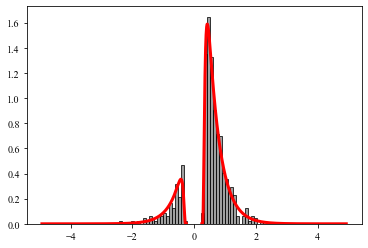

In [3]:
# parameters for simulated data
phi = {'t_nd' : 0.25, # non-decision time
          'w' : 0.5,  # relative start point
         'mu' : 1.0,  # drift rate
          'a' : 0.75}  # decision threshold location

# simulate data
rt = pbd.simulate_model(N_sims = 500,   # number of data points to simulate
                         model = model, # model dictionary
                           phi = phi,   # parameters used to simulate data
                          seed = 123)  # rng seed

# plot simulated data and model likelihood function
pbd.plot_rt(model = model,          # model dictionary
              phi = phi,            # parameters used for model likelihood
               rt = rt, bins = 50); # dictionary of simulated rt data


In [4]:
# define model priors
p = {'pt_nd' : 'Uniform("t_nd", lower = 0.0, upper = 0.75)', # prior for non-decision time
        'pw' : 'Uniform("w", lower = 0.3, upper = 0.7)',     # prior for relative start point
       'pmu' : 'Uniform("mu", lower = -5.0, upper = 5.0)',   # prior for drift rate
        'pa' : 'Uniform("a", lower = 0.1, upper = 1.0)'}     # prior for decision threshold

# define model conditions
c = {'rt' : rt,      # dictionary containing reaction time data
   't_nd' : 'pt_nd', # sets prior used for non-decision time, references p['pt_nd']
      'w' : 'pw',    # sets prior used for relative start point, references p['pw']
     'mu' : 'pmu',   # sets prior used for the drift rate, references p['pmu']
      'a' : 'pa'}    # sets prior used prior for the threshold, references p['pa']

# load conditions into dictionary
cond = {0 : c}

# run parameter inference
trace = pbd.inference(model = model,   # model dictionary
                     priors = p,       # priors dictionary
                 conditions = cond,    # conditions dictionary 
                    samples = 25000,   # number of samples completed per chain
                     chains = 3,       # number of chains
                      cores = 3,       # number of cpu's to run chains on
                  file_name = 'flat' ) # name of output file


Multiprocess sampling (3 chains in 3 jobs)
DEMetropolisZ: [a, mu, w, t_nd]


Sampling 3 chains for 0 tune and 25_000 draw iterations (0 + 75_000 draws total) took 54 seconds.


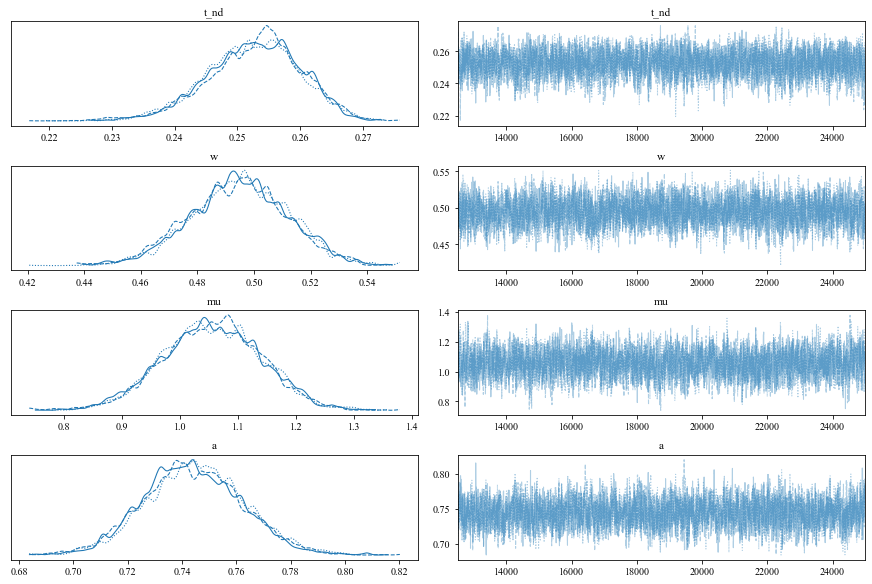

In [5]:
# plot trace
pbd.plot_trace(file_name = 'flat', burnin = 12500);


In [6]:
# navarro analytic solution for the base model
def fpt(v, a, w, t):
    cons = (np.pi/(a*a))*np.exp(-v*a*w - v*v*t/2.0)
    sum_terms = 0.0
    for ii in range(1,1000):
        sum_terms += ii*np.exp(-ii*ii*np.pi*np.pi*t/(2.0*a*a))*np.sin(ii*np.pi*w)
    out = cons*sum_terms
    return out


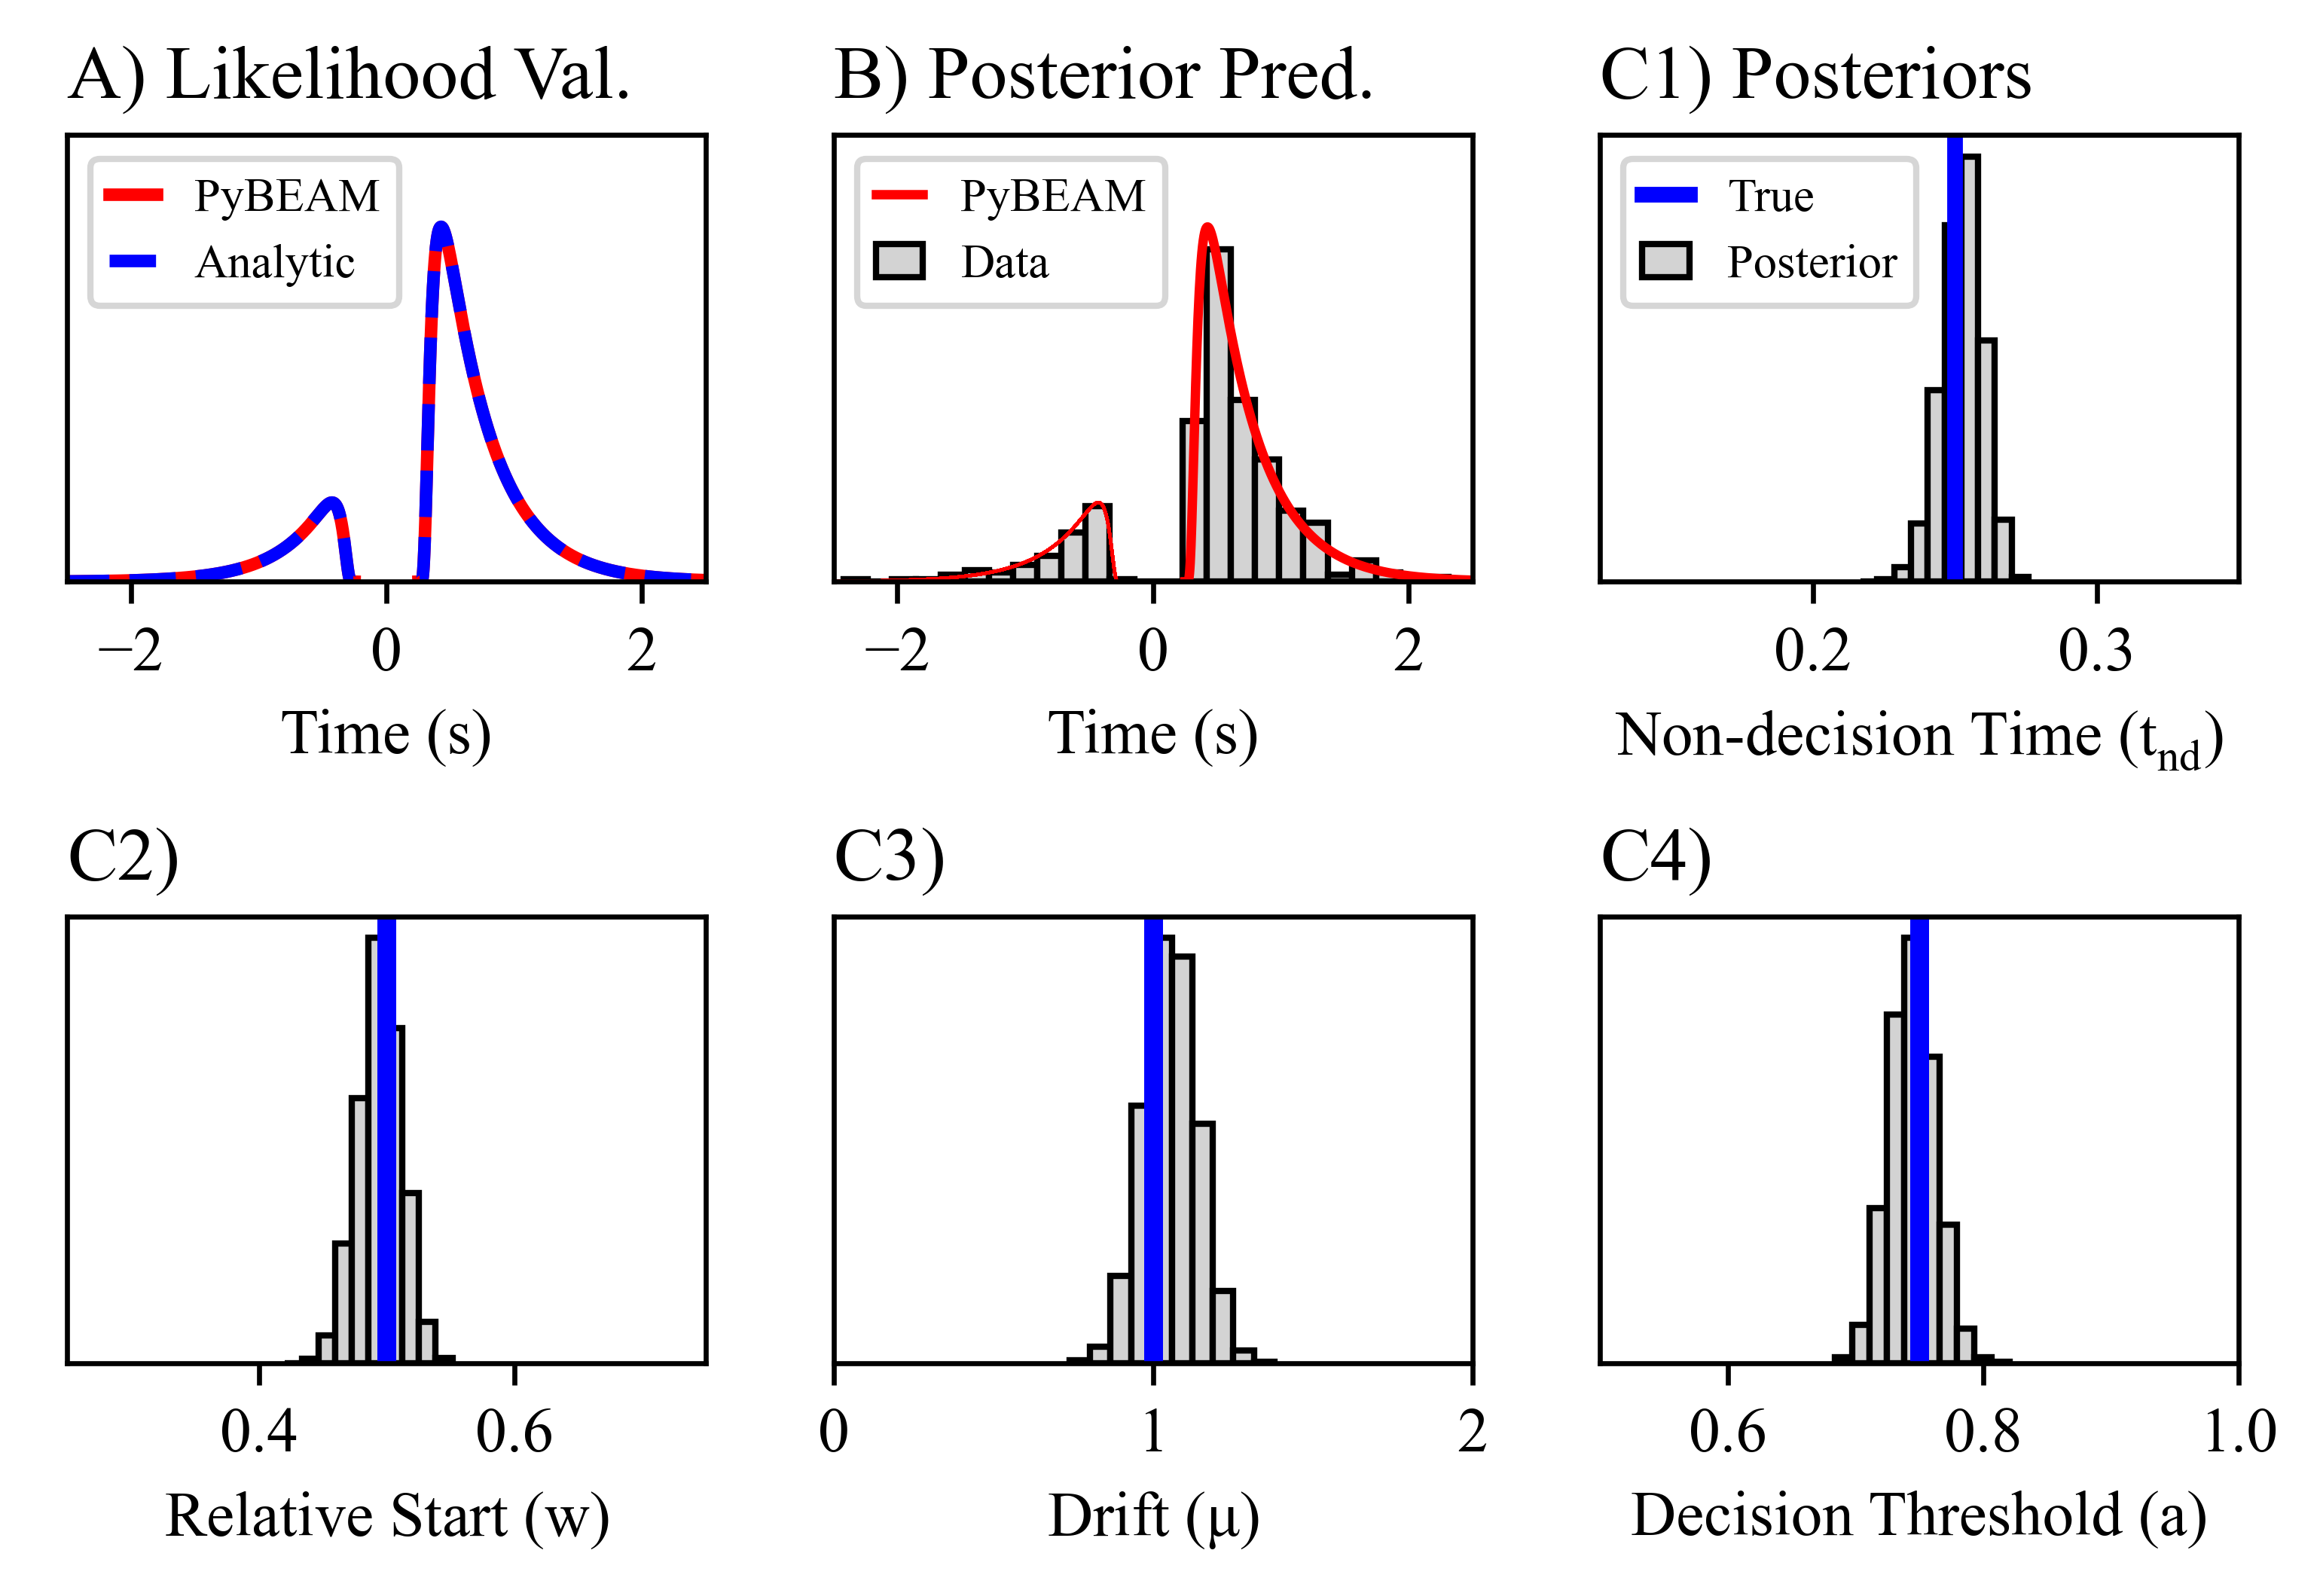

In [10]:
# set figure size and subplot spacing
fig, axs = plt.subplots(2, 3, figsize=(6.2, 3.6), dpi=600);
plt.subplots_adjust(hspace=0.75)

# calculate model likelihood using PyBEAM, and plot in panel [0,0]
model_rt = pbd.model_rt(model = model, phi = phi)
axs[0,0].plot(model_rt['time'], model_rt['model_rt_upper'], color = 'r', linewidth = 2)
axs[0,0].plot(-model_rt['time'], model_rt['model_rt_lower'], color = 'r', label = '_nolegend_', linewidth = 2)
axs[0,0].set_xlim(-2.5, 2.5)

# calculate model likelihood from navarro analytic solution, plot in panel [0,0]
t = np.linspace(0.01, 2.5, 1000)
f_bu = np.zeros_like(t)
f_bl = np.zeros_like(t)
v = 1.0
w = 0.5
a = 0.75
for ii in range(len(t)):
    f_bl[ii] = fpt(v, 2.0*a, w, t[ii])
    f_bu[ii] = fpt(-v, 2.0*a, (1.0 - w), t[ii])
    
axs[0,0].plot(t + 0.25, f_bu, color = 'b', linestyle = '--', linewidth = 2)
axs[0,0].plot(-(t + 0.25), f_bl, color = 'b', linestyle = '--', label = '_nolegend_', linewidth = 2)
axs[0,0].legend(['PyBEAM', 'Analytic'], fontsize = 7.5, handlelength = 1.0)

# import mcmc inference data
file_name = 'flat'
burnin = 12500
trace = az.from_netcdf(file_name + '.nc')
trace = trace.sel(draw=slice(burnin,None))
trace = trace.posterior.stack(draws=("chain", "draw"))

# plot 100 random values from the posteriors in panel [0,1]
t_nd = trace.t_nd.values
w = trace.w.values
mu = trace.mu.values
a = trace.a.values
N_pp = 100
for ii in range(N_pp):
    
    ind = np.random.randint(0, len(t_nd))
    t_nd_ind = t_nd[ind]
    w_ind = w[ind]
    mu_ind = mu[ind]
    a_ind = a[ind]    
    phi_temp = {'t_nd' : t_nd_ind, 'w' : w_ind, 'mu' : mu_ind, 'a' : a_ind}
       
    rt_model = pbd.model_rt(model = model, phi = phi)
    if (ii == 0):
        axs[0,1].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r')
        axs[0,1].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label = '_nolegend_')
    else:
        axs[0,1].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r', linewidth = 0.5, label='_nolegend_')
        axs[0,1].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label='_nolegend_')
         
# plot histogram of simulated data in panel [0,1]
axs[0,1].set_xlim(-2.5, 2.5)
rt_all = np.concatenate((rt['rt_upper'], -rt['rt_lower']))  
axs[0,1].hist(rt_all, density = True, bins = 25, edgecolor = 'k', facecolor = 'lightgrey');
axs[0,1].legend(['PyBEAM', 'Data'], fontsize = 7.5, loc = 'upper left', handlelength = 1)

# plot histogram of non-decision time posterior
axs[0,2].hist(t_nd, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[0,2].axvline(x=0.25, c = 'b', linewidth = 2.5)
axs[0,2].set_xlim(0.125, 0.35)
axs[0,2].set_xlabel('Non-decision Time ($t_{nd}$)')
axs[0,2].legend(['True', 'Posterior'], fontsize = 7.5, loc = 'upper left', handlelength = 1.0)

# plot histogram of relative start posterior
axs[1,0].hist(w, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,0].axvline(x=0.5, c = 'b', linewidth = 3)
axs[1,0].set_xlim(0.25, 0.75)
axs[1,0].set_xlabel('Relative Start ($w$)')

# plot histogram of drift rate posterior
axs[1,1].hist(mu, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,1].axvline(x=1.0, c = 'b', linewidth = 3)
axs[1,1].set_xlim(0.0, 2.0)
axs[1,1].set_xlabel('Drift ($\mu$)')

# plot histogram of decison threshold posterior
axs[1,2].hist(a, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,2].axvline(x=0.75, c = 'b', linewidth = 3)
axs[1,2].set_xlim(0.5, 1.0)
axs[1,2].set_xlabel('Decision Threshold (a)')

# add remaining axis labels and titles
axs[0,0].set_xlabel('Time (s)')
axs[0,0].set_title('A) Likelihood Val.', loc = 'left')

axs[0,1].set_xlabel('Time (s)')
axs[0,1].set_title('B) Posterior Pred.', loc = 'left')

axs[0,2].set_title('C1) Posteriors', loc = 'left')
axs[1,0].set_title('C2)', loc = 'left')
axs[1,1].set_title('C3)', loc = 'left')
axs[1,2].set_title('C4)', loc = 'left')

axs[0,0].set_ylim(0.0, 2.0)
axs[0,1].set_ylim(0.0, 2.0)

# remove yticks and ytick labels
for ii in range(2):
    for jj in range(3):
        axs[ii,jj].set_yticklabels([])
        axs[ii,jj].set_yticks([])

# save figure as pdf
plt.savefig('flat.pdf', bbox_inches = 'tight', dpi = 600)
        